## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%config InlineBackend.figure_formats = ['svg']
from scipy.signal import savgol_filter

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
import time
from tqdm import tqdm
from copy import deepcopy

In [4]:
def add_subplot_axes(ax,rect,facecolor='w'): # matplotlib 2.0+
# def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
#     subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

## Data

In [5]:
np.random.seed(42)
zs = np.random.normal(size=(1000, 2))
zs_test = np.random.normal(size=(1000, 2))

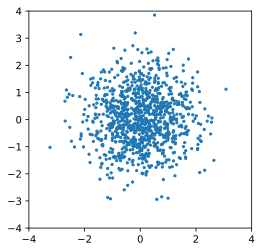

In [6]:
plt.figure(figsize=(4, 4))
plt.scatter(zs[:,0], zs[:,1], s=5)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [7]:
W = np.array([
    [-0.5, -1],
    [-1, -1],
    [2, 0.5]
])
sigma = np.array([0.4, 0.2, 0.3])

In [8]:
mus = (W @ zs.T).T
xs = mus + np.random.normal(size=mus.shape) * sigma

In [9]:
mus_test = (W @ zs_test.T).T
xs_test = mus_test + np.random.normal(size=mus_test.shape) * sigma
xs_test_torch = torch.from_numpy(xs_test).float()

In [10]:
def scatter3d(xs, color="lightblue", s=15):
    plt.gca().scatter(xs[:,0], xs[:,1], xs[:,2], s=s, edgecolor='black', alpha=0.5, color=color)
    plt.xlabel(r"$\mathbf{x}_1$")
    plt.ylabel(r"$\mathbf{x}_2$")
    plt.gca().set_zlabel(r"$\mathbf{x}_3$")

def scatter2d(xs, dim1, dim2, color="lightblue", s=15, labels_off=False):
    plt.gca().scatter(xs[:,dim1], xs[:,dim2], s=s, edgecolor='black', alpha=0.5, color=color)
    
    if not labels_off:
    
        if dim1 == 0:
            plt.xlabel(r"$\mathbf{x}_1$")
        elif dim1 == 1:
            plt.xlabel(r"$\mathbf{x}_2$")

        if dim2 == 1:
            plt.ylabel(r"$\mathbf{x}_2$")
        elif dim2 == 2:
            plt.ylabel(r"$\mathbf{x}_3$")
            
    else:
        plt.xlabel("")
        plt.ylabel("")
    
def extra_config():
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_xlim(-7, 7)
    plt.gca().set_ylim(-7, 7)
    plt.grid()

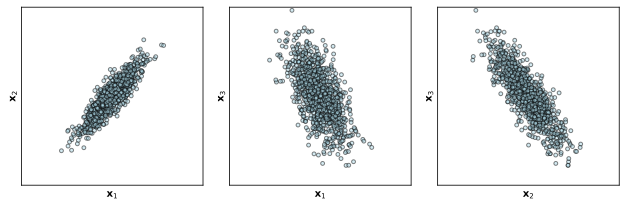

In [11]:
fig = plt.figure(figsize=(8.85, 3))

# ax = fig.add_subplot(141, pojection="3d")
# scatter3d(xs)
# sns.kdeplot(x=xs[:,0], y=xs[:,1], ax=ax) #offset=-100)
# cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax = fig.add_subplot(131)
scatter2d(xs, 0, 1)
extra_config()

ax = fig.add_subplot(132)
scatter2d(xs, 0, 2)
extra_config()

ax = fig.add_subplot(133)
scatter2d(xs, 1, 2)
extra_config()

plt.tight_layout()

plt.savefig("fa_data.pdf")

## Modules

In [12]:
class p_x_given_z_class(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(data=torch.randn(3, 2))
        self.pre_sigma = nn.Parameter(data=torch.randn(3))
       
    @property
    def sigma(self):
        return F.softplus(self.pre_sigma)
        
    def forward(self, zs):
        mus = (self.W @ zs.T).T 
        return D.Independent(D.Normal(mus, self.sigma), reinterpreted_batch_ndims=1)

In [13]:
D.MultivariateNormal?

In [14]:
p_x_given_z = p_x_given_z_class()
p_x_given_z(torch.randn(100, 2))

Independent(Normal(loc: torch.Size([100, 3]), scale: torch.Size([100, 3])), 1)

In [15]:
class q_z_given_x_class(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.V = nn.Parameter(data=torch.randn(2, 3))
        self.cov_decomp = nn.Parameter(torch.linalg.cholesky(torch.eye(2), upper=True))
       
    @property
    def cov(self):
        temp = torch.triu(self.cov_decomp)
        return temp.T @ temp
        
    def forward(self, xs):
        mus = (self.V @ xs.T).T  # mus can be obtained by a linear transformation
        return D.MultivariateNormal(mus, self.cov)  # covariance is shared

## AEVB

In [16]:
class AEVB:
    
    def __init__(self, lr=1e-2):
        
        self.p_z = D.MultivariateNormal(torch.zeros(2), torch.eye(2))
        self.p_x_given_z = p_x_given_z_class()
        self.q_z_given_x = q_z_given_x_class()
        
        self.p_x_given_z_opt = optim.Adam(self.p_x_given_z.parameters(), lr=lr)
        self.q_z_given_x_opt = optim.Adam(self.q_z_given_x.parameters(), lr=lr)
        
        self.zs_rand = None
    
    def sample(self, n):
        self.p_x_given_z.eval()
        self.q_z_given_x.eval()
        with torch.no_grad():
            return self.p_x_given_z(self.p_z.sample((n, ))).sample()
       
    def step(self, xs, evaluate=False, stop_training_generative=False, stop_training_inference=False):
        if evaluate:
            self.p_x_given_z.eval()
            self.q_z_given_x.eval()
        else:
            if stop_training_generative:
                self.p_x_given_z.eval()
            else:
                self.p_x_given_z.train()
            if stop_training_inference:
                self.q_z_given_x.eval()
            else:
                self.q_z_given_x.train()
        posterior_over_zs = self.q_z_given_x(xs)
        # kl-divergence
        kl = D.kl.kl_divergence(posterior_over_zs, self.p_z).mean()
        # reconstruction
        zs = posterior_over_zs.rsample()  # sample using the re-parametrization trick
        #kl = ((posterior_over_zs.log_prob(zs) - self.p_z.log_prob(zs))).mean()
        rec = self.p_x_given_z(zs).log_prob(xs).mean()
        # elbo (estimated using one sample per posterior)
        elbo = - kl + rec
        # backpropagation and gradient step
        loss = - elbo
        if not evaluate:
            self.p_x_given_z_opt.zero_grad()
            self.q_z_given_x_opt.zero_grad()
            loss.backward()
            if not stop_training_generative:
                self.p_x_given_z_opt.step()
            if not stop_training_inference:
                self.q_z_given_x_opt.step()
        return {
            "kl": float(kl),  # this is at least 0; the smaller the better
            "rec": float(rec),  # the larger the better
            "elbo": float(elbo)  # the larger the better
        }
    
#     def estimate_evidence(self, xs, debug=False) -> float:
#         # vectorized code for estimating evidence
#         # no longer needed after compute evidence is implemented
        
#         zs_rand = torch.randn(size=(1000, 2))
#         dists = self.p_x_given_z(zs_rand)
        
#         # # keep the original, pre-vectorization code here for reference:
#         # for i in range(len(xs)):
#         #    sample = np.exp(dists.log_prob(torch.from_numpy(xs[i])).detach().numpy())
#         #    samples.append(np.log(np.mean(sample)))
        
#         log_probs = dists.log_prob(xs.unsqueeze(1))
#         if debug:
#             print(log_probs.shape)
#         return float(log_probs.exp().mean(dim=1).log().mean())
    
    def compute_evidence(self, xs, debug=False) -> float:
        
        W = self.p_x_given_z.W
        Phi = (self.p_x_given_z.sigma * torch.eye(3)) ** 2
        dist = D.MultivariateNormal(torch.zeros(3), Phi + W @ W.T)
        
        return float(dist.log_prob(xs).mean())

In [17]:
aevb = AEVB()

In [18]:
torch.manual_seed(42)
start = time.time()
est_evidence = aevb.compute_evidence(xs_test_torch, debug=True)
print(est_evidence)
end = time.time()
end - start

-8.062457084655762


0.0005891323089599609

In [19]:
class p_x_given_z_truth_class():
    
    def __init__(self):
        super().__init__()
        self.W = torch.from_numpy(W)
        self.sigma = torch.from_numpy(sigma)
        
    def __call__(self, zs):
        mus = (self.W @ zs.T).T 
        return D.Independent(D.Normal(mus, self.sigma), reinterpreted_batch_ndims=1)

## Experiment 1

In [20]:
torch.manual_seed(42)

xs_torch = torch.from_numpy(xs).float()
ds = TensorDataset(xs_torch)
dl = DataLoader(ds, batch_size=32)

aevb = AEVB()

kls, recs, elbos = [], [], []
elbos_test = []
evidences = []

steps_elapsed = 0
aevbs = []

for epoch in tqdm(range(35)):
    for (xb, ) in dl:
        
        output = aevb.step(xb)
        output_test = aevb.step(xs_test_torch, evaluate=True)
        
        kls.append(output["kl"])
        recs.append(output["rec"])
        elbos.append(output["elbo"])
        elbos_test.append(output_test["elbo"])
        
        evidences.append(aevb.compute_evidence(xs_test_torch))
        
        steps_elapsed += 1
        
        if steps_elapsed in [5, 100, 800]:
            aevbs.append(deepcopy(aevb))

100%|█████████████████████████████████████████████| 35/35 [00:01<00:00, 17.87it/s]


In [21]:
aevb_true = AEVB()
aevb_true.p_x_given_z = p_x_given_z_truth_class()
evidence_true_model = aevb_true.compute_evidence(xs_test_torch.double())

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(elbos_test[:1000], label="Estimated ELBO of learned model (test set)", linewidth=1, color="red")
plt.xlim([0, 1000])
plt.xlabel("# gradient step")
plt.xticks([0, 200, 400, 600, 800, 1000])

plt.plot(evidences[:1000], label="Evidence of learned model (test set)", linewidth=1, color="green")
plt.axhline(evidence_true_model, label="Evidence of true model (test set)", color="black", linestyle="--", linewidth=1)

plt.legend(loc="lower right", frameon=False)

# ==========

plt.gca().annotate("", xy=(10, -13), xytext=(50, -13),
            arrowprops=dict(arrowstyle="->"))

plt.gca().annotate("", xy=(100, -6), xytext=(433, -8),
            arrowprops=dict(arrowstyle="->"))

plt.gca().annotate("", xy=(800, -4.5), xytext=(800, -7),
            arrowprops=dict(arrowstyle="->"))

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

base_ax = plt.gca()

# ==========

add_subplot_axes(base_ax, [0.05,0.10,0.1,0.25])
scatter2d(aevbs[0].sample(1000).numpy(), 0, 1, color="orange", s=10, labels_off=True)
scatter2d(xs_test, 0, 1, s=10, labels_off=True)
extra_config()

add_subplot_axes(base_ax, [0.15,0.10,0.1,0.25])
scatter2d(aevbs[0].sample(1000).numpy(), 0, 2, color="orange", s=10, labels_off=True)
scatter2d(xs_test, 0, 2, s=10, labels_off=True)
extra_config()

inner1 = add_subplot_axes(base_ax, [0.25,0.10,0.1,0.25])
scatter2d(aevbs[0].sample(1000).numpy(), 1, 2, color="orange", s=10, labels_off=True)
scatter2d(xs_test, 1, 2, s=10, labels_off=True)
extra_config()

# ==========

inner2 = add_subplot_axes(base_ax, [0.30,0.4,0.1,0.25])
scatter2d(aevbs[1].sample(1000).numpy(), 0, 1, color="orange", s=10, labels_off=True)
scatter2d(xs_test, 0, 1, s=10, labels_off=True)
extra_config()

inner2 = add_subplot_axes(base_ax, [0.40,0.4,0.1,0.25])
scatter2d(aevbs[1].sample(1000).numpy(), 0, 2, color="orange", s=10, labels_off=True)
scatter2d(xs_test, 0, 2, s=10, labels_off=True)
extra_config()

inner2 = add_subplot_axes(base_ax, [0.50,0.4,0.1,0.25])
scatter2d(aevbs[1].sample(1000).numpy(), 1, 2, color="orange", s=10, labels_off=True)
scatter2d(xs_test, 1, 2, s=10,labels_off=True)
extra_config()

# ==========

inner3 = add_subplot_axes(base_ax, [0.65,0.5,0.1,0.25])
scatter2d(aevbs[2].sample(1000).numpy(), 0, 1, color="orange", s=10, labels_off=True)
scatter2d(xs_test, 0, 1, s=10, labels_off=True)
extra_config()

inner3 = add_subplot_axes(base_ax, [0.75,0.5,0.1,0.25])
scatter2d(aevbs[2].sample(1000).numpy(), 0, 2, color="orange", s=10,labels_off=True)
scatter2d(xs_test, 0, 2, s=10,labels_off=True)
extra_config()

inner3 = add_subplot_axes(base_ax, [0.85,0.5,0.1,0.25])
scatter2d(aevbs[2].sample(1000).numpy(), 1, 2, color="orange", s=10,labels_off=True)
scatter2d(xs_test, 1, 2, s=10,labels_off=True)
extra_config()

plt.savefig("fa_learning_curve.pdf", bbox_inches='tight',pad_inches = 0)

## Experiment 2

In [23]:
torch.manual_seed(42)

xs_torch = torch.from_numpy(xs).float()
xs_test_torch = torch.from_numpy(xs_test).float()
ds = TensorDataset(xs_torch)
dl = DataLoader(ds, batch_size=32)

aevb = AEVB()

kls, recs, elbos = [], [], []
elbos_test = []
evidences = []

steps_elapsed = 0
aevbs = []

for epoch in tqdm(range(130)):
    for (xb,) in dl:
    
        if steps_elapsed < 1000:
            output = aevb.step(xb, stop_training_generative=True)
        elif 2000 >= steps_elapsed > 1000 :
            output = aevb.step(xb, stop_training_inference=True)
        elif 3000 >= steps_elapsed > 2000 :
            output = aevb.step(xb, stop_training_generative=True)
        elif 4000 >= steps_elapsed > 3000 :
            output = aevb.step(xb, stop_training_inference=True)
        output_test = aevb.step(xs_test_torch, evaluate=True)
        
        kls.append(output["kl"])
        recs.append(output["rec"])
        elbos.append(output["elbo"])
        elbos_test.append(output_test["elbo"])
        
        evidences.append(aevb.compute_evidence(xs_test_torch))
        
        steps_elapsed += 1

100%|███████████████████████████████████████████| 130/130 [00:07<00:00, 18.54it/s]


In [24]:
def axvspan(left, right):
    plt.axvspan(left, right, color="gray", alpha=0.2)

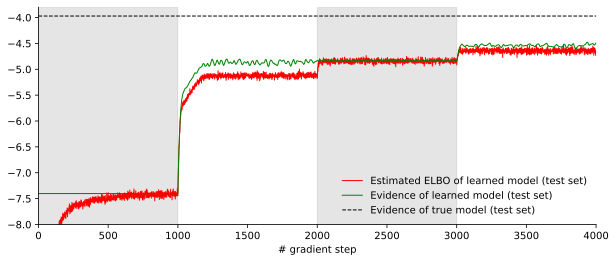

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(elbos_test[:4000], color="red", label="Estimated ELBO of learned model (test set)", linewidth=1)
plt.plot(evidences[:4000], color="green", label="Evidence of learned model (test set)", linewidth=1)
plt.axhline(evidence_true_model, label="Evidence of true model (test set)", color="black", linestyle="--", linewidth=1)
axvspan(0, 999)
axvspan(2000, 3000)

plt.xlim(0, 4000)
plt.ylim(-8, -3.8)

plt.xlabel("# gradient step")
plt.legend(loc="lower right", frameon=False)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.savefig("fa_learning_curve_em.pdf", bbox_inches='tight',pad_inches = 0)